## K-Means Clustering Workflow


### 1. Load required libraries

In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import warnings
import matplotlib.cm as cm
warnings.filterwarnings('ignore')

#SKLearn libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

#The following code requires 'pip install kneed' to be run. This is for the elbow method used in Step 4 onwards for analysis.
from kneed import KneeLocator



### 2. Load feature engineered data

In [2]:
customer_purchase_df = pd.read_csv("../../data/processed/df_eng_customer_purchasing_features.csv")
print("Data loaded. Shape:", customer_purchase_df.shape)

#Show first 5 rows of data
customer_purchase_df.head()

Data loaded. Shape: (238, 29)


,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency,region_grouped,region_North,region_South,...,is_frequent,is_champion,income_percentile,spending_percentile,growth_potential_score,age_adjusted_percentile,frequency_percentile,log_purchase_amount,log_annual_income,log_purchase_frequency
0,1,25,45000,200,4.5,North,12,North,True,False,...,False,False,0.1408,0.0735,74,0.3333,0-25%,5.2983,10.7144,2.4849
1,2,34,55000,350,7.0,South,18,South,False,True,...,False,False,0.4181,0.2920,100,0.2613,25-50%,5.8579,10.9151,2.8904
2,3,45,65000,500,8.0,West,22,West,False,False,...,False,False,0.6996,0.6702,57,0.1118,50-75%,6.2146,11.0821,3.0910
3,4,22,30000,150,3.0,East,10,North,True,False,...,False,False,0.0042,0.0042,44,0.0196,0-25%,5.0106,10.3090,2.3026
4,5,29,47000,220,4.8,North,13,North,True,False,...,False,False,0.2080,0.0819,100,0.3824,0-25%,5.3936,10.7579,2.5649


### 3. Preprocess Features
For KMeans, non-numeric features will need to be converted to integers or ordinal encoding.
Examples: 
    Key Segments/Flags --> True will have value of 1, False will have value of 0.
    Demographics and Income brackets --> Encode as ordinal


In [3]:
# Convert boolean columns to integers (1 for True, 0 for False)
boolean_columns = ['is_high_value', 'is_loyal', 'is_frequent', 'is_champion']
customer_purchase_df[boolean_columns] = customer_purchase_df[boolean_columns].astype(int)

# Encode region_grouped as ordinal, add them to dataframe
region_grouped_encode = {
    'North': 0,
    'West': 1,
    'South': 2
}
customer_purchase_df['region_grouped_encoded'] = customer_purchase_df['region_grouped'].map(region_grouped_encode)

# Encode age_group as ordinal, add them to dataframe
age_group_encode = {
    'Young_Adult': 0,
    'Adult': 1,
    'Middle_Aged': 2,
    'Senior': 3
}
customer_purchase_df['age_group_encoded'] = customer_purchase_df['age_group'].map(age_group_encode)

# Encode income_bracket as ordinal, add them to dataframe
income_bracket_encode = {
    'Low_Income': 0,
    'Medium_Income': 1,
    'High_Income': 2
}
customer_purchase_df['income_bracket_encoded'] = customer_purchase_df['income_bracket'].map(income_bracket_encode)

# Encode frequencye_percentile as decimals, add them to dataframe
frequency_percentile_encode = {
    '0-25%': 0.25,
    '25-50%': 0.5,
    '50-75%': 0.75,
    '75-100%': 1
}
customer_purchase_df['frequency_percentile_encoded'] = customer_purchase_df['frequency_percentile'].map(frequency_percentile_encode)


# Overwrite the categorical columns with the updated columns 
customer_purchase_df['region_grouped'] = customer_purchase_df['region_grouped_encoded']
customer_purchase_df['age_group'] = customer_purchase_df['age_group_encoded']
customer_purchase_df['income_bracket'] = customer_purchase_df['income_bracket_encoded']
customer_purchase_df['frequency_percentile'] = customer_purchase_df['frequency_percentile_encoded']
customer_purchase_df.drop(columns=['region_grouped_encoded', 'age_group_encoded', 'income_bracket_encoded', 'frequency_percentile_encoded'], inplace=True)

# Save updated dataframe
customer_purchase_df.to_csv("df_eng_customer_purchasing_features_encoded.csv", index=False)

In [4]:
#Review updated dataframe:
customer_purchase_df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
print("Data loaded. Shape:", customer_purchase_df.shape)

#Show first 5 rows of data
customer_purchase_df.head()

Data loaded. Shape: (238, 29)


,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency,region_grouped,region_North,region_South,...,is_frequent,is_champion,income_percentile,spending_percentile,growth_potential_score,age_adjusted_percentile,frequency_percentile,log_purchase_amount,log_annual_income,log_purchase_frequency
0,1,25,45000,200,4.5,North,12,0,True,False,...,0,0,0.1408,0.0735,74,0.3333,0.25,5.2983,10.7144,2.4849
1,2,34,55000,350,7.0,South,18,2,False,True,...,0,0,0.4181,0.2920,100,0.2613,0.50,5.8579,10.9151,2.8904
2,3,45,65000,500,8.0,West,22,1,False,False,...,0,0,0.6996,0.6702,57,0.1118,0.75,6.2146,11.0821,3.0910
3,4,22,30000,150,3.0,East,10,0,True,False,...,0,0,0.0042,0.0042,44,0.0196,0.25,5.0106,10.3090,2.3026
4,5,29,47000,220,4.8,North,13,0,True,False,...,0,0,0.2080,0.0819,100,0.3824,0.25,5.3936,10.7579,2.5649


### 4. Run KMeans Clustering, Identify Clusters, Analysis
We will run KMeans Clustering on the updated dataset - we will be using two methods to this approach:

   1. Elbow method - we will first test a range of k clusters to calculate WCSS (within cluster sum of squares), and want lower values. We then identify the "elbow", which shows a sharp decrease in rate of change of WCSS as k increases. This first helps us identify the best value of k to use as the number of clusters for the clustering.
   2. Silhouette Scoring - for KMeans clustering, the silhouette score is a metric use to evaluate the quality of clustering, and seeing values closer to 1 indicate better clustering.

For our analysis, we will use the k value from the silhouette scoring, because the score helps measure how well the cluster values are distinct from the others. Furthermore:
   - We want to try and distinguish clear customer groups to identify customer purchasing behaviours,
   - Businesses looking to identify and understand customer profiles may need the additional differentiation or nuance,
   - Having more separation will improve targeting their ideal market(s). 
For testing, the maximum number of clusters is set to 10, and the iterations are also set to 10.

After each set of features, we will analyze if these clusters are useful for the overall objective,and any additional considerations.

All plots and updated CSV files with clusters are saved in folder: (`experiments/kmeans_clustering`)


In [5]:
#Define feature sets, using updated encoded features
feature_sets = {
    "core_scores": ['customer_value_score', 'churn_risk_score', 'growth_potential_score'],
    "behavioural_ratios": ['spend_per_purchase', 'spend_to_income_ratio'],
    "key_segment_flags": ['is_high_value', 'is_loyal', 'is_frequent', 'is_champion'],
    "demographics_income": ['age_group', 'age_adjusted_percentile','income_bracket'],
    "percentiles": ['income_percentile', 'spending_percentile', 'frequency_percentile'],
    "log_transformed": ['log_purchase_amount', 'log_annual_income', 'log_purchase_frequency']
}

#Create folder to store results
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

### 4A. Base Fields Analysis
This section runs KMeans Clustering analysis on the following features: (`age`, `annual_income`, `purchase_amount`, `loyalty_score`, `annual_income`, `region_grouped`, `purchase_frequency`).

Clustering for feature set: base_fields
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 5
Best k (by silhouette) for base_fields: 10. Silhouette score of 0.6110


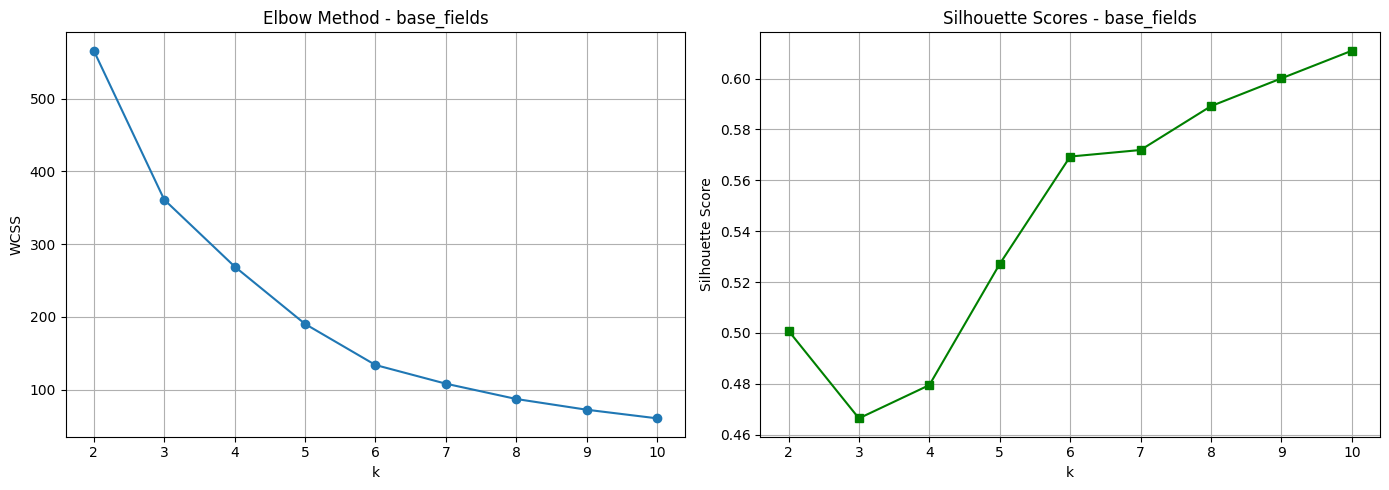

CLUSTER METRICS FOR k = 10
Cluster 0: 15 samples, avg silhouette = 0.452
Cluster 1: 42 samples, avg silhouette = 0.560
Cluster 2: 22 samples, avg silhouette = 0.581
Cluster 3: 14 samples, avg silhouette = 0.924
Cluster 4: 36 samples, avg silhouette = 0.609
Cluster 5: 19 samples, avg silhouette = 0.788
Cluster 6: 37 samples, avg silhouette = 0.665
Cluster 7: 17 samples, avg silhouette = 0.426
Cluster 8: 17 samples, avg silhouette = 0.533
Cluster 9: 19 samples, avg silhouette = 0.611


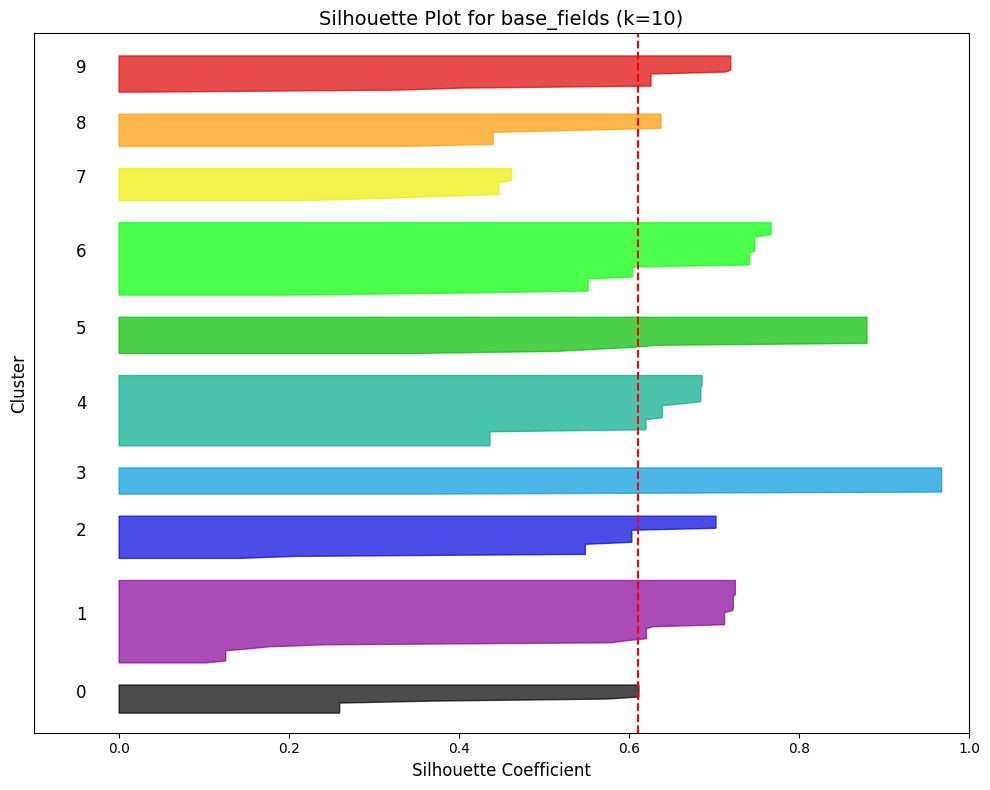

In [6]:
#Use only base features:
set_name = "base_fields"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [7]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_base_fields.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['base_fields_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['base_fields_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('base_fields_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")

print('='*60)
print("RANKING OF CLUSTER BY LOYALTY, PURCHASE AMOUNT, FREQUENCY, INCOME:") 
print('='*60)

# Rank clusters by Loyalty, Purchase Amount, Frequency, Income
cluster_stats_sorted = cluster_stats.sort_values(by=['loyalty_score', 'purchase_amount', 'purchase_frequency', 'annual_income'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 10
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 15 customers (6.30%)
  Cluster 1: 42 customers (17.65%)
  Cluster 2: 22 customers (9.24%)
  Cluster 3: 14 customers (5.88%)
  Cluster 4: 36 customers (15.13%)
  Cluster 5: 19 customers (7.98%)
  Cluster 6: 37 customers (15.55%)
  Cluster 7: 17 customers (7.14%)
  Cluster 8: 17 customers (7.14%)
  Cluster 9: 19 customers (7.98%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 54.33
  Average Annual Income: 74333.33
  Average Purchase Amount: 633.33
  Average Loyalty Score: 9.43
  Average Region (Grouped): 1.60
  Average Purchase Frequency: 27.40

Cluster 1:
  Average Age: 27.50
  Average Annual Income: 44738.10
  Average Purchase Amount: 245.95
  Average Loyalty Score: 4.30
  Average Region (Grouped): 0.05
  Average Purchase Frequency: 14.14

Cluster 2:
  Average Age: 39.36
  Average Annual Income: 59590.91
  Average Purchase Amount: 448.64
  Average Loyalty Score: 7.21
  Average R

**Comments:** We start by analyzing the base fields as a starting point - while the data is synthetic, it's important to set a baseline to see what improvements can be seen when using the other engineered features for clustering.

The base silhouette score already shows solid separation of clusters at a value of 0.611, and the clusters have shown a distribution where no cluster is less than 5% of the total dataset. 

The based features shows that it can create very distinct customer profiles in the clusters, and the information from them is very easily identifiable. This shows that when using real data, if the same features are used to cluster for customer profiling, it will do a good job in doing so for business stakeholders.

For example: Cluster 0 is for seniors with the highest income and spending power, while Cluster 3 is a young adult with low disposable income.  



### 4B. Core Scores Analysis
This section runs KMeans Clustering analysis on the following features in addition to the base fields: (`customer_value_score`, `churn_risk_score`, `growth_potential_score`).

Clustering for feature set: core_scores
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 6
Best k (by silhouette) for core_scores: 8. Silhouette score of 0.5466


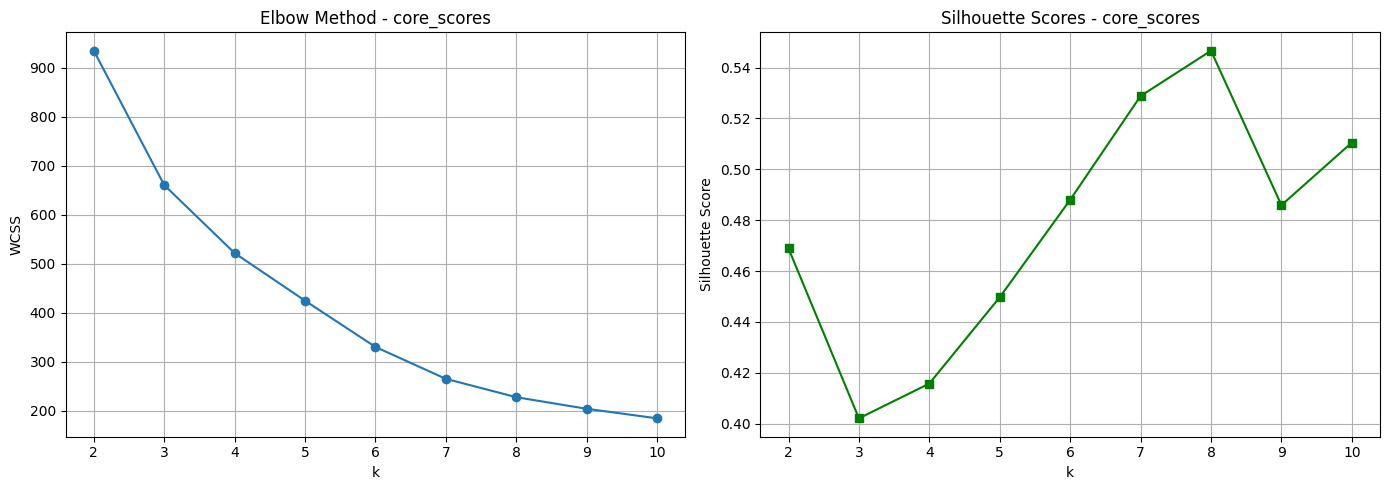

CLUSTER METRICS FOR k = 8
Cluster 0: 5 samples, avg silhouette = 0.310
Cluster 1: 60 samples, avg silhouette = 0.600
Cluster 2: 29 samples, avg silhouette = 0.486
Cluster 3: 41 samples, avg silhouette = 0.345
Cluster 4: 16 samples, avg silhouette = 0.756
Cluster 5: 27 samples, avg silhouette = 0.611
Cluster 6: 15 samples, avg silhouette = 0.575
Cluster 7: 45 samples, avg silhouette = 0.602


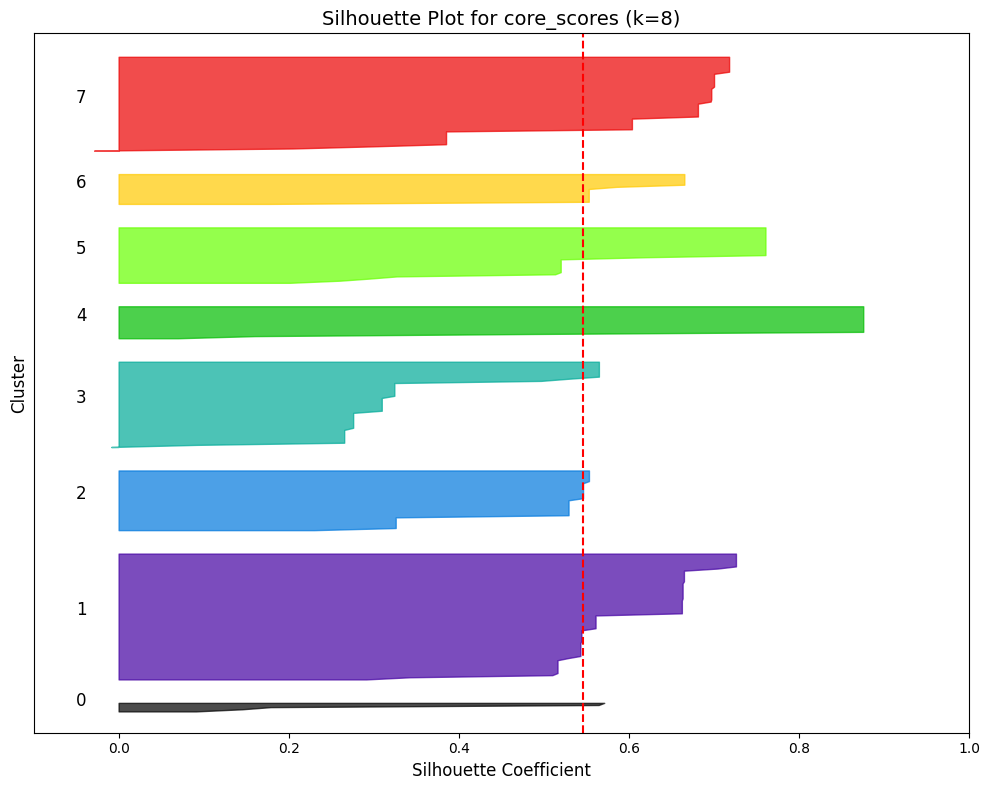

In [8]:
#Use only core_scores features:
set_name = "core_scores"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'customer_value_score', 'churn_risk_score', 'growth_potential_score']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [9]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_core_scores.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'churn_risk_score', 'customer_value_score', 'growth_potential_score'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['core_scores_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['core_scores_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('core_scores_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'customer_value_score': 'mean',
    'churn_risk_score': 'mean',
    'growth_potential_score': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  Average Customer Value: {cluster_stats.loc[cluster, 'customer_value_score']:.2f}")
    print(f"  Average Churn Risk: {cluster_stats.loc[cluster, 'churn_risk_score']:.2f}")
    print(f"  Average Growth Potential: {cluster_stats.loc[cluster, 'growth_potential_score']:.2f}")


print('='*60)
print("RANKING OF CLUSTERS BY CUSTOMER VALUE SCORE, CHURN RISK SCORE, AND GROWTH POTENTIAL SCORE:") 
print('='*60)

# Rank clusters by customer value and growth potential
cluster_stats_sorted = cluster_stats.sort_values(by=['customer_value_score', 'churn_risk_score', 'growth_potential_score'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  Average Customer Value: {row['customer_value_score']:.2f}")
    print(f"  Average Churn Risk: {row['churn_risk_score']:.2f}")
    print(f"  Average Growth Potential: {row['growth_potential_score']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 8
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 5 customers (2.10%)
  Cluster 1: 60 customers (25.21%)
  Cluster 2: 29 customers (12.18%)
  Cluster 3: 41 customers (17.23%)
  Cluster 4: 16 customers (6.72%)
  Cluster 5: 27 customers (11.34%)
  Cluster 6: 15 customers (6.30%)
  Cluster 7: 45 customers (18.91%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 28.40
  Average Annual Income: 47800.00
  Average Purchase Amount: 238.00
  Average Loyalty Score: 4.94
  Average Region (Grouped): 0.20
  Average Purchase Frequency: 13.80
  Average Customer Value: 0.22
  Average Churn Risk: 0.75
  Average Growth Potential: 89.60

Cluster 1:
  Average Age: 51.07
  Average Annual Income: 71066.67
  Average Purchase Amount: 601.50
  Average Loyalty Score: 9.05
  Average Region (Grouped): 1.02
  Average Purchase Frequency: 25.47
  Average Customer Value: 0.91
  Average Churn Risk: 0.10
  Average Growth Potential: 43.88

Cluster 2:
  Average Age:

**Comments:** Of all the runs, the core scores has the worst silhoutte value of 0.55 (which is not that poor overall) - which may be due to the result of combining multiple metrics that were created from the base values. However, it's usage is likely the most important for what we're trying to achieve.

Sales, customer loyalty, customer churn, and upselling are top of mind for anyone looking to optimize their business operations and succeed, as they answer questions like:
*   Will this customer leave/return to our business?
*   Are they capable and/or willing to spend more?
*   Where are these people located?
 These are important for understanding customer behaviours to roll out strategies like targeting specific markets, customer retention and customer appreciation.
 
 The 8 clusters likely represent distinct customer categories, and the strategies can be used as such - for example:
*   Cluster 1 would be a high value loyal customer --> could use customer appreciation strategy
*   Cluster 6 has high value and high growth potential --> can use growth marketing strategy
*   Cluster 4 is high risk customer, with low value --> can exclude from target markets

### 4C. Behavioural Ratios Analysis
This section runs KMeans Clustering analysis on the following features: (`spend_per_purchase`, `spend_to_income_ratio`).

Clustering for feature set: behavioural_ratios
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 4
Best k (by silhouette) for behavioural_ratios: 10. Silhouette score of 0.5574


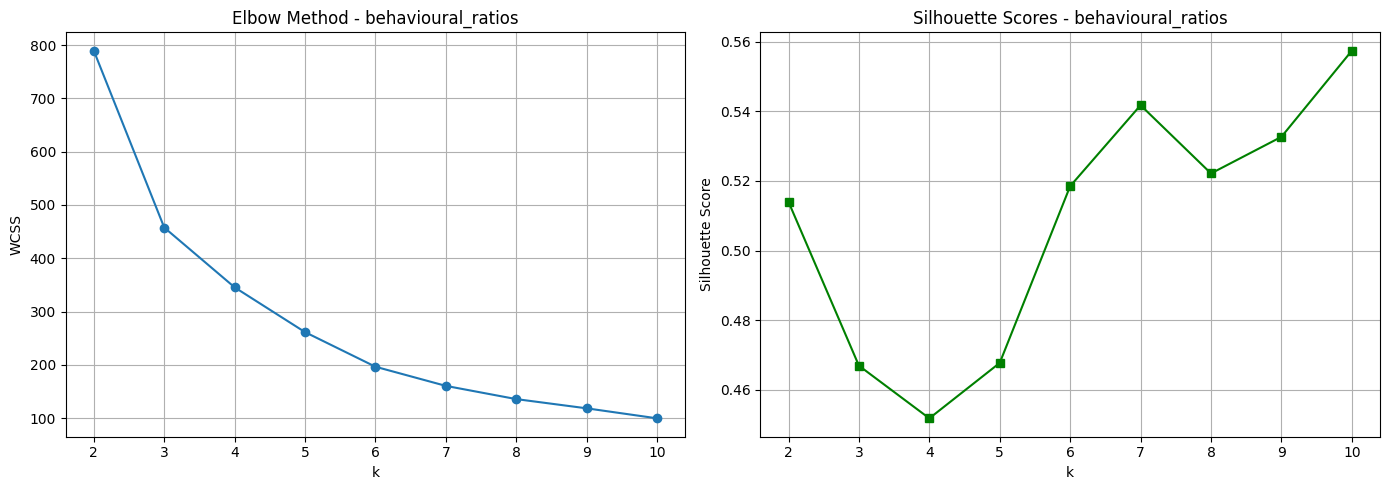

CLUSTER METRICS FOR k = 10
Cluster 0: 19 samples, avg silhouette = 0.688
Cluster 1: 50 samples, avg silhouette = 0.401
Cluster 2: 36 samples, avg silhouette = 0.608
Cluster 3: 36 samples, avg silhouette = 0.517
Cluster 4: 17 samples, avg silhouette = 0.713
Cluster 5: 14 samples, avg silhouette = 0.925
Cluster 6: 24 samples, avg silhouette = 0.329
Cluster 7: 22 samples, avg silhouette = 0.458
Cluster 8: 9 samples, avg silhouette = 0.897
Cluster 9: 11 samples, avg silhouette = 0.721


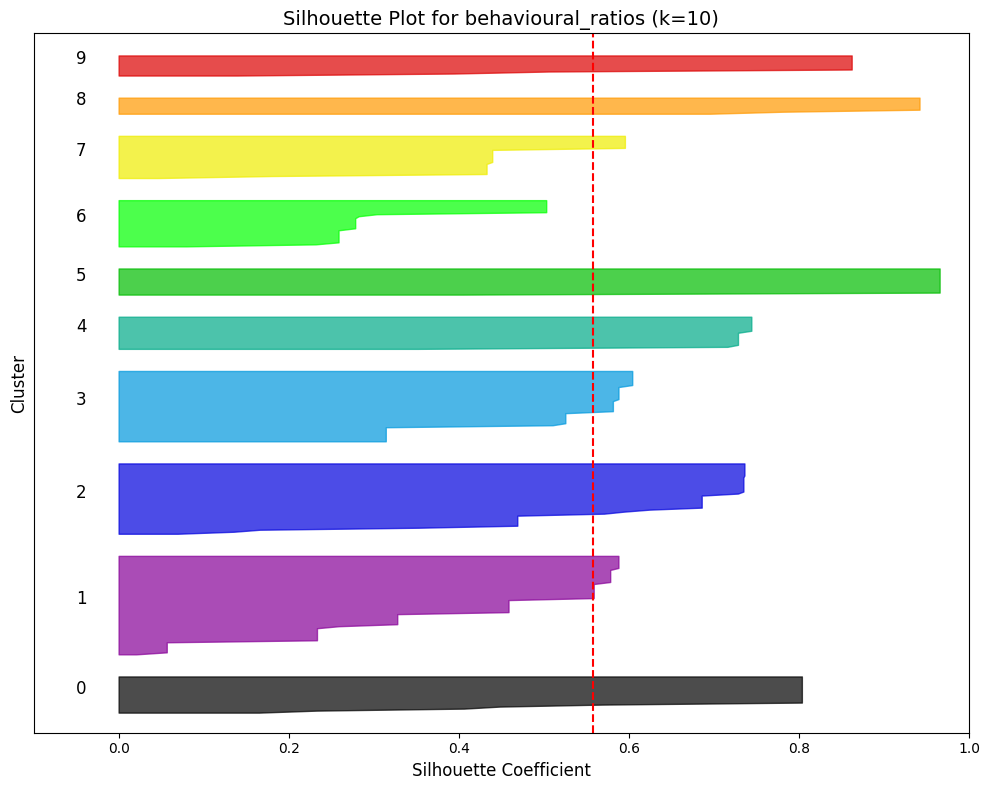

In [10]:
#Use only core_scores features:
set_name = "behavioural_ratios"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'spend_per_purchase', 'churn_risk_score', 'spend_to_income_ratio']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [11]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_behavioural_ratios.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'spend_to_income_ratio', 'spend_per_purchase'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['behavioural_ratios_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['behavioural_ratios_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.4f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('behavioural_ratios_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'spend_per_purchase': 'mean',
    'spend_to_income_ratio': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  Average Spend to Income Ratio: {cluster_stats.loc[cluster, 'spend_to_income_ratio']:.4f}")
    print(f"  Average Spend per Purchase: {cluster_stats.loc[cluster, 'spend_per_purchase']:.4f}")

print('='*60)
print("RANKING OF CLUSTERS BY SPEND TO INCOME RATIO AND SPEND PER PURCHASE:") 
print('='*60)

# Rank clusters by spend to income ratio and spend per purchase
cluster_stats_sorted = cluster_stats.sort_values(by=['spend_to_income_ratio', 'spend_per_purchase'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  Average Spend to Income Ratio: {row['spend_to_income_ratio']:.4f}")
    print(f"  Average Spend per Purchase: {row['spend_per_purchase']:.2f}")

    cluster_rank += 1


Total customers: 238
Number of clusters: 10
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 19 customers (7.9832%)
  Cluster 1: 50 customers (21.0084%)
  Cluster 2: 36 customers (15.1261%)
  Cluster 3: 36 customers (15.1261%)
  Cluster 4: 17 customers (7.1429%)
  Cluster 5: 14 customers (5.8824%)
  Cluster 6: 24 customers (10.0840%)
  Cluster 7: 22 customers (9.2437%)
  Cluster 8: 9 customers (3.7815%)
  Cluster 9: 11 customers (4.6218%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 32.68
  Average Annual Income: 52631.58
  Average Purchase Amount: 366.32
  Average Loyalty Score: 5.91
  Average Region (Grouped): 2.00
  Average Purchase Frequency: 17.79
  Average Spend to Income Ratio: 0.0070
  Average Spend per Purchase: 20.5612

Cluster 1:
  Average Age: 50.62
  Average Annual Income: 70620.00
  Average Purchase Amount: 597.60
  Average Loyalty Score: 9.00
  Average Region (Grouped): 0.86
  Average Purchase Frequency: 25.22
  Average Spend to Income Ratio: 0.0085
  Av

**Comments:** The takeaways from this clustering are similar to the core scores thoughts - they both have the lowest silhouette scores (not by much), but also end up providing the most information for the customer behaviour. 

Unlike demographic clustering, this one specifically focuses on consumer psychology, habits, and patterns - which help businesses strategize how to craft tailored customer experiences, messaging, or campaigns. For example, identifying certain customers as shopaholics (high frequency, high spend per purchase, high spending of income), or other ones being frugal spenders (opposite values).



### 4D. Key Segments/Flags Analysis
This section runs KMeans Clustering analysis on the following features: (`is_high_value`, `is_loyal`, `is_frequent`, `is_champion`).

Clustering for feature set: key_segment_flags
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 3
Best k (by silhouette) for key_segment_flags: 2. Silhouette score of 0.6411


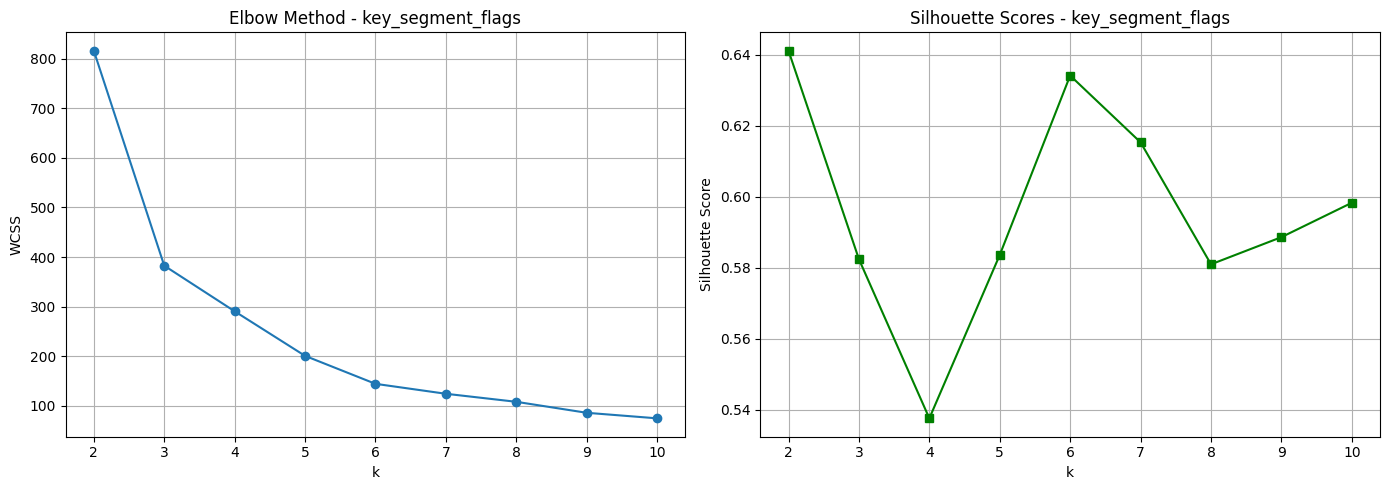

CLUSTER METRICS FOR k = 2
Cluster 0: 60 samples, avg silhouette = 0.828
Cluster 1: 178 samples, avg silhouette = 0.578


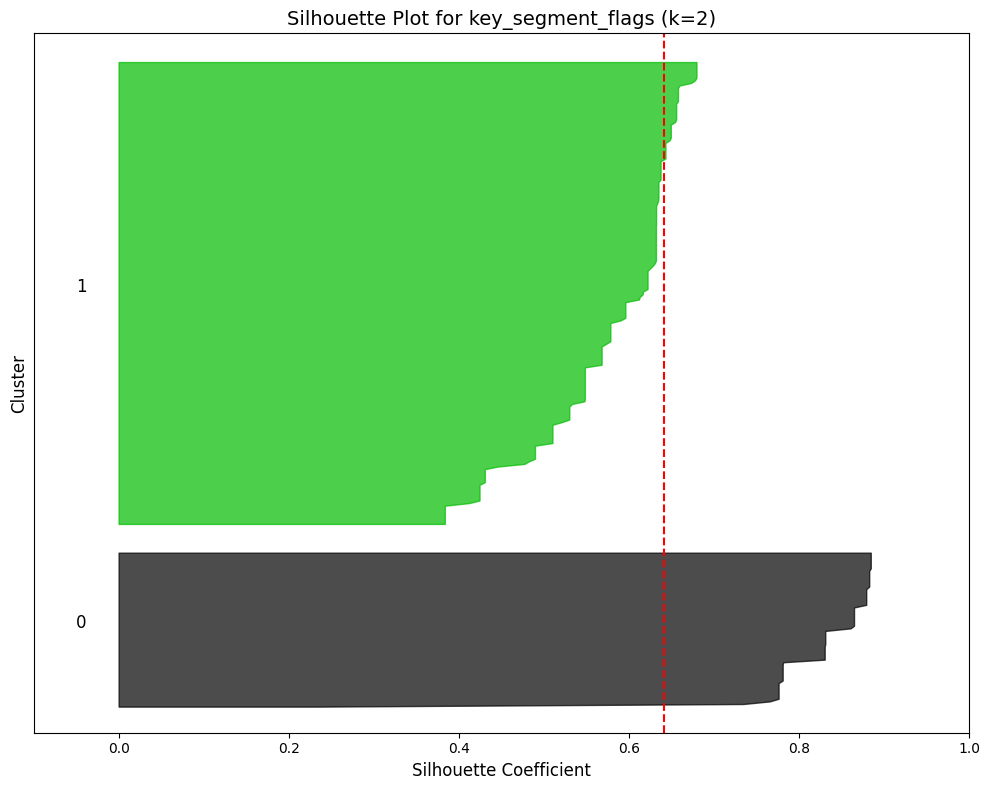

In [12]:
#Use only core_scores features:
set_name = "key_segment_flags"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'is_high_value', 'is_loyal', 'is_frequent', 'is_champion']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [13]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_key_segment_flags.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'is_high_value', 'is_loyal', 'is_frequent', 'is_champion'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['key_segment_flags_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['key_segment_flags_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('key_segment_flags_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'is_high_value': 'mean',
    'is_loyal': 'mean',
    'is_frequent': 'mean',
    'is_champion': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  High Value (Top 25% in Spending): {cluster_stats.loc[cluster, 'is_high_value']:.2f}")
    print(f"  High Loyalty (Top 25% in Loyalty Score ): {cluster_stats.loc[cluster, 'is_loyal']:.2f}")
    print(f"  Frequent Shopper (Top 25% in Purchase Frequency): {cluster_stats.loc[cluster, 'is_frequent']:.2f}")
    print(f"  Champion (Satisfies previous 3): {cluster_stats.loc[cluster, 'is_champion']:.2f}")


print('='*60)
print("RANKING OF CLUSTERS BY CHAMPION FLAG, HIGH VALUE, LOYALTY, AND FREQUENT SHOPPING:") 
print('='*60)

# Rank clusters by Champion Flag, High Value Flag, Loyalty Flag, and Frequent Flag.
cluster_stats_sorted = cluster_stats.sort_values(by=['is_champion', 'is_high_value', 'is_loyal', 'is_frequent'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  High Value (Top 25% in Spending): {row['is_high_value']:.2f}")
    print(f"  High Loyalty (Top 25% in Loyalty Score): {row['is_loyal']:.2f}")
    print(f"  Frequent Shopper (Top 25% in Purchase Frequency): {row['is_frequent']:.2f}")
    print(f"  Champion (Satisfies previous 3): {row['is_champion']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 2
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 60 customers (25.21%)
  Cluster 1: 178 customers (74.79%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 51.07
  Average Annual Income: 71066.67
  Average Purchase Amount: 601.50
  Average Loyalty Score: 9.05
  Average Region (Grouped): 1.02
  Average Purchase Frequency: 25.47
  High Value (Top 25% in Spending): 1.00
  High Loyalty (Top 25% in Loyalty Score ): 1.00
  Frequent Shopper (Top 25% in Purchase Frequency): 0.98
  Champion (Satisfies previous 3): 0.98

Cluster 1:
  Average Age: 34.50
  Average Annual Income: 52803.37
  Average Purchase Amount: 366.35
  Average Loyalty Score: 6.03
  Average Region (Grouped): 0.96
  Average Purchase Frequency: 17.89
  High Value (Top 25% in Spending): 0.00
  High Loyalty (Top 25% in Loyalty Score ): 0.00
  Frequent Shopper (Top 25% in Purchase Frequency): 0.00
  Champion (Satisfies previous 3): 0.00
RANKING OF CLUSTERS BY CHAMPION FLAG, HIG

**Comments:** At first glance, Key Segment Flags feature set appears to be the best scores of 0.64, since it has such a high silhouette score of 0.996, but this is due to the binary nature of the features themselves - it cannot be interpreted as being the best feature for clusters outright.

However, the binary nature of the features do help with identifying clear customer profiles and behaviours (i.e. are they loyal? are they a frequent shopper?) - and this is immediately useful for customer targeting. It's a simple metric that can be used to identify the superstar customers, which give enough information about their purchasing behaviours. 

Because of this nature, this will miss any customers that may have the potential to reach this tier, or even as a general opportunity.

### 4E. Demographics & Income Brackets Analysis
This section runs KMeans Clustering analysis on the following features: (`age_group`, `age_adjusted_percentile`, `income_bracket`).

Clustering for feature set: demographics_income
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 4
Best k (by silhouette) for demographics_income: 9. Silhouette score of 0.5723


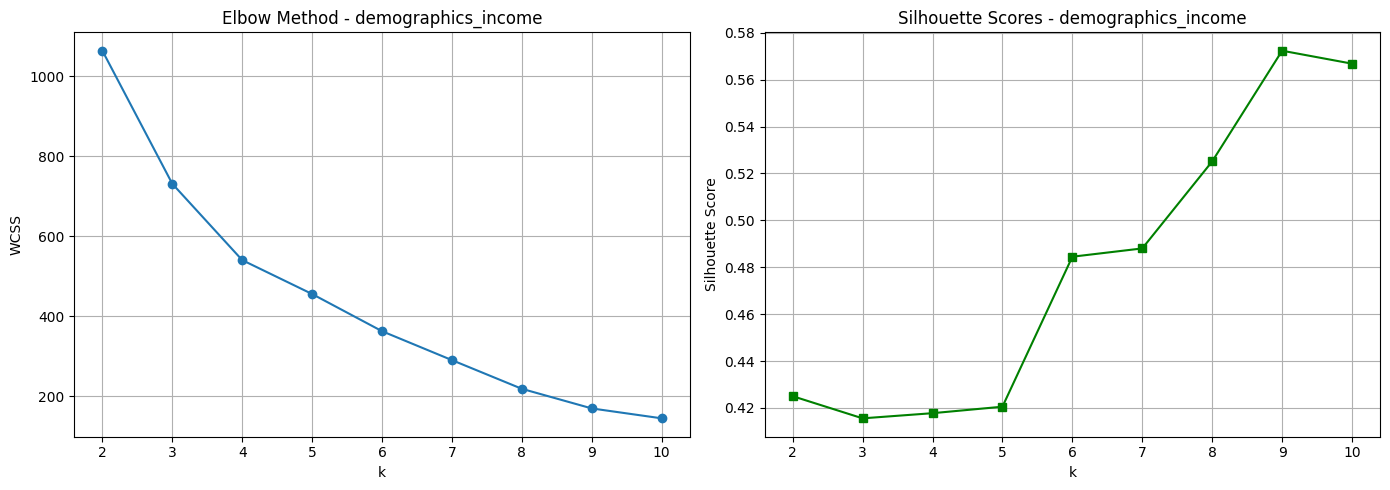

CLUSTER METRICS FOR k = 9
Cluster 0: 19 samples, avg silhouette = 0.543
Cluster 1: 44 samples, avg silhouette = 0.470
Cluster 2: 35 samples, avg silhouette = 0.428
Cluster 3: 15 samples, avg silhouette = 0.817
Cluster 4: 17 samples, avg silhouette = 0.865
Cluster 5: 32 samples, avg silhouette = 0.452
Cluster 6: 35 samples, avg silhouette = 0.628
Cluster 7: 25 samples, avg silhouette = 0.627
Cluster 8: 16 samples, avg silhouette = 0.696


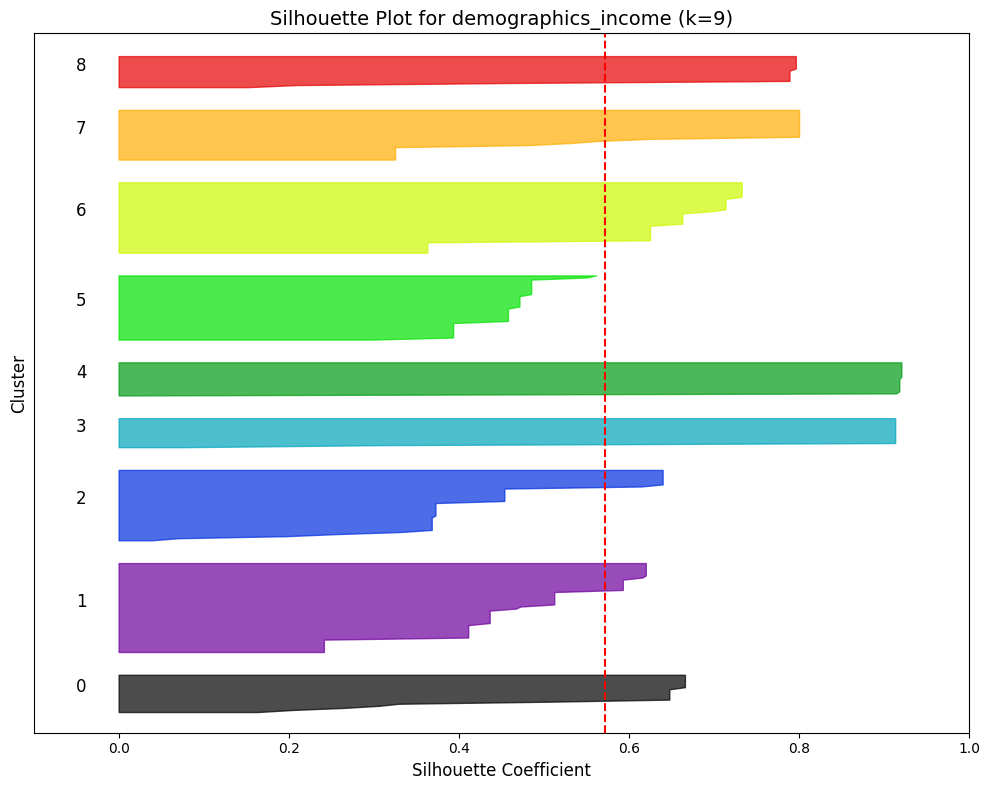

In [14]:
#Use only core_scores features:
set_name = "demographics_income"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'age_group', 'age_adjusted_percentile', 'income_bracket']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [15]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_demographics_income.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'age_group', 'age_adjusted_percentile', 'income_bracket'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['demographics_income_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['demographics_income_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('demographics_income_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'age_group': 'mean',
    'age_adjusted_percentile': 'mean',
    'income_bracket': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  Average Age Group: {cluster_stats.loc[cluster, 'age_group']:.2f}")
    print(f"  Average Age Percentile: {cluster_stats.loc[cluster, 'age_adjusted_percentile']:.2f}")
    print(f"  Average Income Bracket: {cluster_stats.loc[cluster, 'income_bracket']:.2f}")


print('='*60)
print("RANKING OF CLUSTERS BY INCOME BRACKET, AGE GROUP, AGE ADJUSTED PERCENTILE:") 
print('='*60)

# Rank clusters by Income bracket, Age Group, and Age Adjusted Percentile
cluster_stats_sorted = cluster_stats.sort_values(by=['income_bracket', 'age_group', 'age_adjusted_percentile'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  Average Age Group: {row['age_group']:.2f}")
    print(f"  Average Age Percentile: {row['age_adjusted_percentile']:.2f}")
    print(f"  Average Income Bracket: {row['income_bracket']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 9
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 19 customers (7.98%)
  Cluster 1: 44 customers (18.49%)
  Cluster 2: 35 customers (14.71%)
  Cluster 3: 15 customers (6.30%)
  Cluster 4: 17 customers (7.14%)
  Cluster 5: 32 customers (13.45%)
  Cluster 6: 35 customers (14.71%)
  Cluster 7: 25 customers (10.50%)
  Cluster 8: 16 customers (6.72%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 28.16
  Average Annual Income: 46105.26
  Average Purchase Amount: 249.47
  Average Loyalty Score: 4.34
  Average Region (Grouped): 0.21
  Average Purchase Frequency: 14.11
  Average Age Group: 0.00
  Average Age Percentile: 0.70
  Average Income Bracket: 1.00

Cluster 1:
  Average Age: 52.02
  Average Annual Income: 72022.73
  Average Purchase Amount: 613.41
  Average Loyalty Score: 9.19
  Average Region (Grouped): 1.05
  Average Purchase Frequency: 26.02
  Average Age Group: 2.00
  Average Age Percentile: 0.72
  Average Income Bracket: 1.00

**Comments:** The demographics approach is a more traditional approach for segmenting the customer profiles and achieves a silhoueete score of 0.57 - slightly worse than the base set but still solid differentiation. The percentiles help give provide a more relative breakdown of the customers that can scale especially with the more standard demographic features. 

Relative to the other sets, it's pretty easy to interpret the results and easily fits in with regular customer segmentation, or more traiditional marketing ones - however, it may need to be combined with behavioural data to identify better purchasing behaviour patterns.


### 4F. Percentiles Analysis
This section runs KMeans Clustering analysis on the following features: (`income_percentile`, `spending_percentile`, `frequency_percentile`).

Clustering for feature set: percentiles
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 5
Best k (by silhouette) for percentiles: 7. Silhouette score of 0.5654


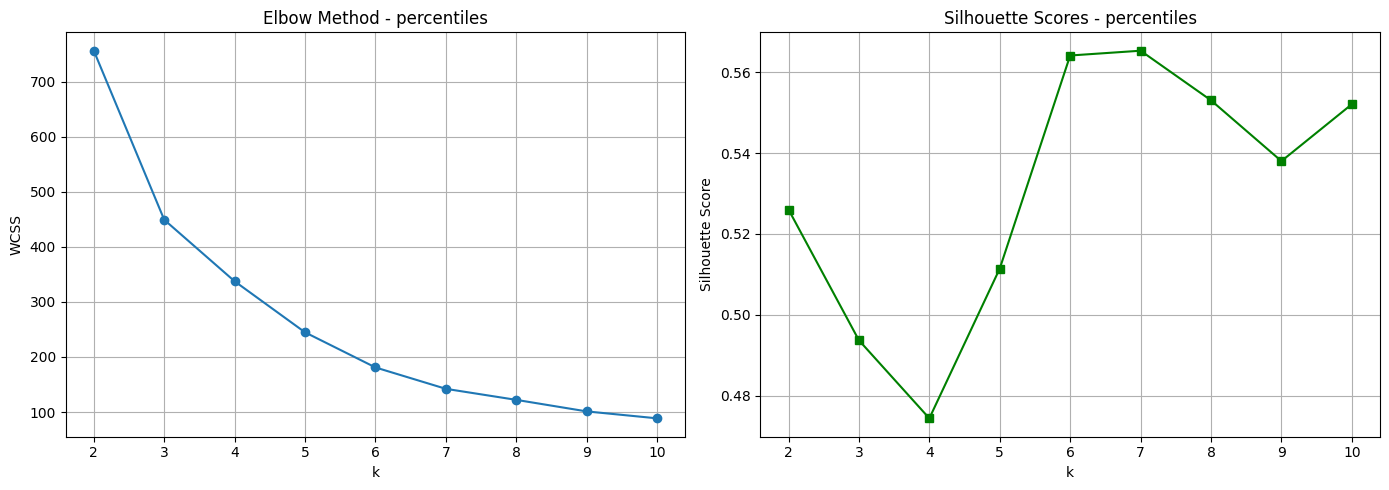

CLUSTER METRICS FOR k = 7
Cluster 0: 48 samples, avg silhouette = 0.644
Cluster 1: 43 samples, avg silhouette = 0.566
Cluster 2: 19 samples, avg silhouette = 0.439
Cluster 3: 16 samples, avg silhouette = 0.736
Cluster 4: 51 samples, avg silhouette = 0.539
Cluster 5: 27 samples, avg silhouette = 0.561
Cluster 6: 34 samples, avg silhouette = 0.487


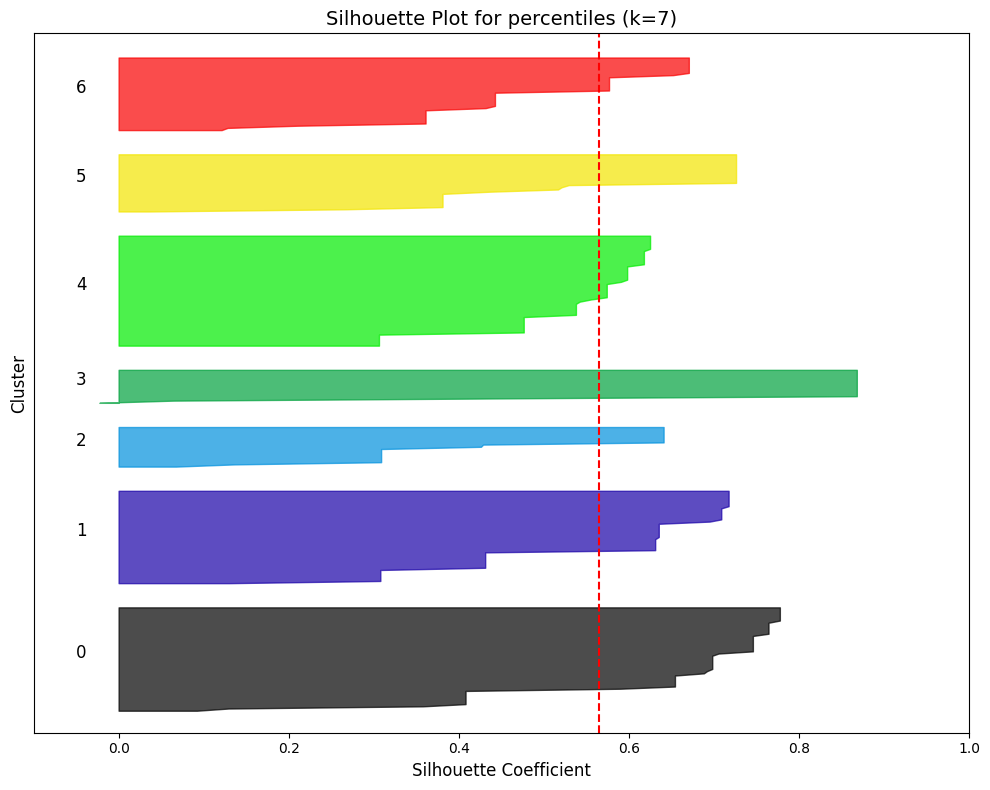

In [16]:
#Use only core_scores features:
set_name = "percentiles"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'income_percentile', 'spending_percentile', 'frequency_percentile']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [17]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_percentiles.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'income_percentile', 'spending_percentile', 'frequency_percentile'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['percentiles_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['percentiles_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('percentiles_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'income_percentile': 'mean',
    'spending_percentile': 'mean',
    'frequency_percentile': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  Average Income Percentile: {cluster_stats.loc[cluster, 'income_percentile']:.2f}")
    print(f"  Average Spending Percentile: {cluster_stats.loc[cluster, 'spending_percentile']:.2f}")
    print(f"  Average Frequency Percentile: {cluster_stats.loc[cluster, 'frequency_percentile']:.2f}")


print('='*60)
print("RANKING OF CLUSTERS BY INCOME PERCENTILE, SPENDING PERCENTILE, FREQUENCY PERCENTILE:") 
print('='*60)

# Rank clusters by Income Percentile, Spending Percentile, Frequency Percentile
cluster_stats_sorted = cluster_stats.sort_values(by=['income_percentile', 'spending_percentile', 'frequency_percentile'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  Average Income Percentile: {row['income_percentile']:.2f}")
    print(f"  Average Spending Percentile: {row['spending_percentile']:.2f}")
    print(f"  Average Frequency Percentile: {row['frequency_percentile']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 7
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 48 customers (20.17%)
  Cluster 1: 43 customers (18.07%)
  Cluster 2: 19 customers (7.98%)
  Cluster 3: 16 customers (6.72%)
  Cluster 4: 51 customers (21.43%)
  Cluster 5: 27 customers (11.34%)
  Cluster 6: 34 customers (14.29%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 28.27
  Average Annual Income: 46333.33
  Average Purchase Amount: 264.58
  Average Loyalty Score: 4.55
  Average Region (Grouped): 0.06
  Average Purchase Frequency: 14.75
  Average Income Percentile: 0.17
  Average Spending Percentile: 0.17
  Average Frequency Percentile: 0.25

Cluster 1:
  Average Age: 41.84
  Average Annual Income: 61488.37
  Average Purchase Amount: 480.23
  Average Loyalty Score: 7.73
  Average Region (Grouped): 1.84
  Average Purchase Frequency: 21.60
  Average Income Percentile: 0.60
  Average Spending Percentile: 0.62
  Average Frequency Percentile: 0.75

Cluster 2:
  Average Age: 47

**Comments:** The percentiles set has a silhouette score of 0.57 - similarly showing decent separation. It focuses on ranking the customers on relative values rather than the true values of the base run - which can help identify customer profiles and behaviours when trying to run a comparative analysis or campaigns. 

Percentiles set also provides a more fair comparison across the different customers, and the different percentiles metrics themselves also help indicate the different behaviours of customers - for example Cluster 3 are for customers who are very frugal with their spending, but Cluster 4 are top spending and frequent shoppers.

### 4G. Log Transformations Analysis
This section runs KMeans Clustering analysis on the following features: (`log_purchase_amount`, `log_annual_income`, `log_purchase_frequency`).

Clustering for feature set: log_transformed
CHOOSING BEST K FROM EACH METHOD
Best k by elbow method is k = 5
Best k (by silhouette) for log_transformed: 9. Silhouette score of 0.5734


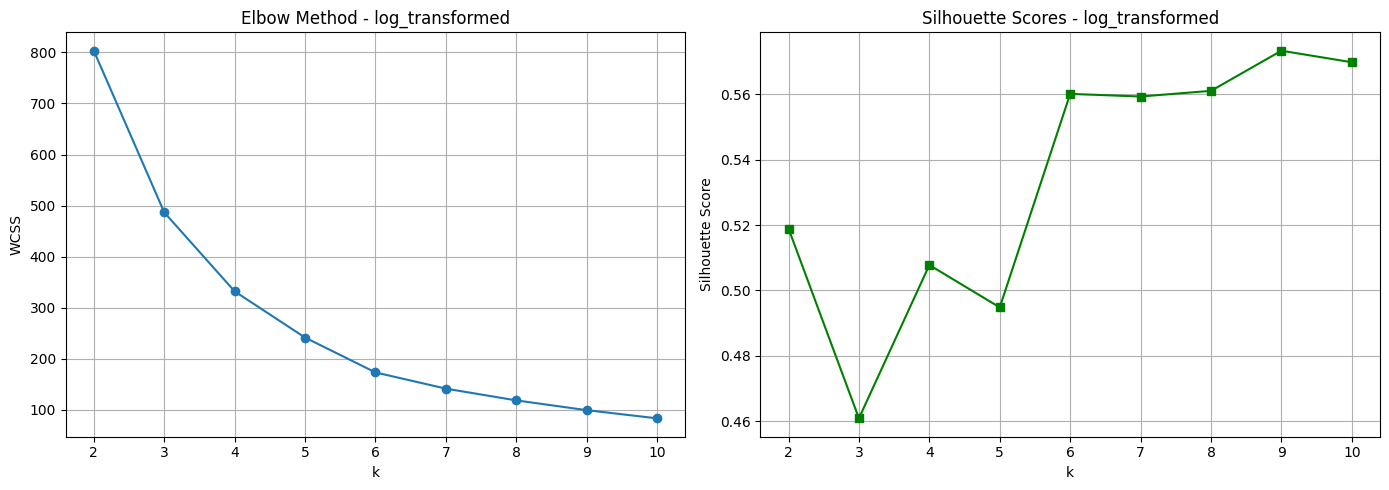

CLUSTER METRICS FOR k = 9
Cluster 0: 52 samples, avg silhouette = 0.515
Cluster 1: 16 samples, avg silhouette = 0.562
Cluster 2: 16 samples, avg silhouette = 0.778
Cluster 3: 19 samples, avg silhouette = 0.571
Cluster 4: 36 samples, avg silhouette = 0.562
Cluster 5: 26 samples, avg silhouette = 0.549
Cluster 6: 34 samples, avg silhouette = 0.649
Cluster 7: 22 samples, avg silhouette = 0.528
Cluster 8: 17 samples, avg silhouette = 0.542


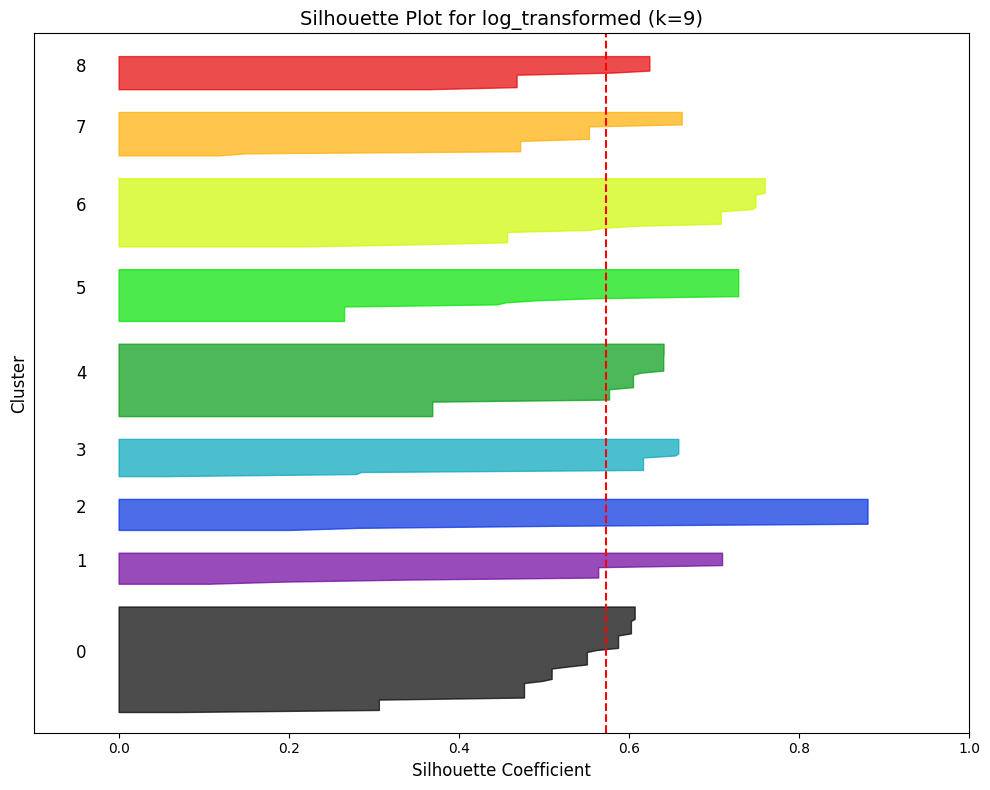

In [18]:
#Use only core_scores features:
set_name = "log_transformed"
clustering_features = ['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'log_purchase_amount', 'log_annual_income', 'log_purchase_frequency']

print(f"Clustering for feature set: {set_name}")

#Get specific features from dataset, using a copy 
X = customer_purchase_df[clustering_features].copy()

#SET UP KMEANS TO RUN ELBOW AND SILHOUETTE SCORING METHOD
#Set up standard scaler
scaler = StandardScaler()

# Create empty lists to hold results. k_range will test from 2 to 10 as values
wcss = []
silhouette_scores = []
k_range = range(2, 11)

# Test each value of k
for k in k_range:

    # Scale and fit the data, create and train the clustering model. Default random state to 42
    X_scaled = scaler.fit_transform(X)
    kmeans_model = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)

    #Calculate and save WCSS (aka intertia function)
    inertia = kmeans_model.inertia_
    wcss.append(inertia)

    #Caluclate and save silhouette score
    silhouette = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette)


#CHOOSING BEST K FROM RESULTS
print('='*60)
print("CHOOSING BEST K FROM EACH METHOD")
print('='*60)


# Choose best k from elbow method
knee = KneeLocator(k_range, wcss, curve = "convex", direction = "decreasing")
elbow_k = knee.knee
print(f"Best k by elbow method is k = {elbow_k}")

# Choose best k from silhouette results
silhouette_k_index = np.argmax(silhouette_scores)
silhouette_k = k_range[silhouette_k_index]
best_silhouette = silhouette_scores[silhouette_k_index]
print(f"Best k (by silhouette) for {set_name}: {silhouette_k}. Silhouette score of {best_silhouette:.4f}")

#Set all best k values from silhouette.
best_k = silhouette_k
best_k_index = list(k_range).index(best_k)
silhouette_for_best_k = silhouette_scores[best_k_index]

# Train final model with best k
X_scaled_final  = scaler.fit_transform(X)
final_kmeans = KMeans(n_clusters = best_k, random_state = 42, n_init = 10)
final_cluster_labels = final_kmeans.fit_predict(X_scaled_final)

#Add cluster labels
cluster_column_name = f"{set_name}_Cluster"
customer_purchase_df[cluster_column_name] = final_cluster_labels

# Save clustered data
out_csv = os.path.join(output_dir, f"clustered_customers_{set_name}.csv")
customer_purchase_df[['user_id'] + clustering_features + [f"{set_name}_Cluster"]].to_csv(out_csv, index=False)

# Create plots of elbow and silhouette values
fig, (ax_elbow, ax_silhouette) = plt.subplots(1, 2, figsize=(14, 5))

ax_elbow.plot(k_range, wcss, marker = 'o')
ax_elbow.set_title(f'Elbow Method - {set_name}')
ax_elbow.set_xlabel('k')
ax_elbow.set_ylabel('WCSS')
ax_elbow.grid(True)

ax_silhouette.plot(k_range, silhouette_scores, marker='s', color='green')
ax_silhouette.set_title(f'Silhouette Scores - {set_name}')
ax_silhouette.set_xlabel('k')
ax_silhouette.set_ylabel('Silhouette Score')
ax_silhouette.grid(True)

# Fit plots for layout
plt.tight_layout()

# Save plots to kmeans folder
plt.savefig(os.path.join(output_dir, f'comparison_{set_name}.png'))
plt.show()


#CREATE SILHOUETTE PLOT
# Calculate silhouette values, can use parameters from final model
silhouette_vals = silhouette_samples(X_scaled_final, final_cluster_labels)
silhouette_avg = silhouette_score(X_scaled_final, final_cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Set limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])

y_lower = 10

print('='*60)
print(f"CLUSTER METRICS FOR k = {best_k}")
print('='*60)

# Plot each cluster
for i in range(best_k):
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[final_cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)
    

    # Print cluster info
    print(f"Cluster {i}: {size_cluster_i} samples, "
          f"avg silhouette = {ith_cluster_silhouette_values.mean():.3f}")
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10


# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title(f'Silhouette Plot for {set_name} (k={best_k})', fontsize=14)
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'silhouette_plot_{set_name}.png'))
plt.show()




In [19]:
#Loading the data into dataframes
df = pd.read_csv("df_eng_customer_purchasing_features_encoded.csv")
clusters = pd.read_csv("outputs/clustered_customers_log_transformed.csv")

#Drop duplicate columns from clustered results before merging
clusters = clusters.drop(['age', 'annual_income', 'purchase_amount', 'loyalty_score', 'region_grouped', 'purchase_frequency', 'log_purchase_amount', 'log_annual_income', 'log_purchase_frequency'], axis=1)

# Merge cluster assignments with main data
df_analysis = df.merge(clusters, on='user_id')

print(f"Total customers: {len(df_analysis)}")
print(f"Number of clusters: {df_analysis['log_transformed_Cluster'].nunique()}")

print('='*60)
print("DISTRIBUTION OF CLUSTERS:") #TItle for showing how clusters are spread
print('='*60)

# Show count of customers in each cluster
print("\nCustomers per cluster:")
cluster_sizes = df_analysis['log_transformed_Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} customers ({size/len(df_analysis)*100:.2f}%)")


print('='*60)
print("DETAILS OF CLUSTERS:") #Title for average metrics of clusters
print('='*60)

# Calculate average scores for each cluster and print results
cluster_stats = df_analysis.groupby('log_transformed_Cluster').agg({
    'age': 'mean',
    'annual_income': 'mean',
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'region_grouped': 'mean',
    'purchase_frequency': 'mean',
    'log_purchase_amount': 'mean',
    'log_annual_income': 'mean',
    'log_purchase_frequency': 'mean'
})

for cluster in cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"  Average Age: {cluster_stats.loc[cluster, 'age']:.2f}")
    print(f"  Average Annual Income: {cluster_stats.loc[cluster, 'annual_income']:.2f}")
    print(f"  Average Purchase Amount: {cluster_stats.loc[cluster, 'purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {cluster_stats.loc[cluster, 'loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {cluster_stats.loc[cluster, 'region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_stats.loc[cluster, 'purchase_frequency']:.2f}")
    print(f"  Average Log Purchase Amount: {cluster_stats.loc[cluster, 'log_purchase_amount']:.2f}")
    print(f"  Average Log Annual Income: {cluster_stats.loc[cluster, 'log_annual_income']:.2f}")
    print(f"  Average Log Purchase Frequency: {cluster_stats.loc[cluster, 'log_purchase_frequency']:.2f}")


print('='*60)
print("RANKING OF CLUSTERS BY LOG PURCHASE, LOG INCOME, LOG PURCHASE FREQUENCY:") 
print('='*60)

# Rank clusters by Log Purchase amount, log annual income, log purchase frequency
cluster_stats_sorted = cluster_stats.sort_values(by=['log_purchase_amount', 'log_annual_income', 'log_purchase_frequency'], ascending=False)

cluster_rank = 1
for cluster in cluster_stats_sorted.index:

    row = cluster_stats_sorted.loc[cluster]

    print(f"\nRank {cluster_rank}: Cluster {cluster}")
    print(f"  Average Age: {row['age']:.2f}")
    print(f"  Average Annual Income: {row['annual_income']:.2f}")
    print(f"  Average Purchase Amount: {row['purchase_amount']:.2f}")
    print(f"  Average Loyalty Score: {row['loyalty_score']:.2f}")
    print(f"  Average Region (Grouped): {row['region_grouped']:.2f}")
    print(f"  Average Purchase Frequency: {row['purchase_frequency']:.2f}")
    print(f"  Average Log Purchase Amount: {row['log_purchase_amount']:.2f}")
    print(f"  Average Log Annual Income: {row['log_annual_income']:.2f}")
    print(f"  Average Log Purchase Frequency: {row['log_purchase_frequency']:.2f}")

    cluster_rank += 1

Total customers: 238
Number of clusters: 9
DISTRIBUTION OF CLUSTERS:

Customers per cluster:
  Cluster 0: 52 customers (21.85%)
  Cluster 1: 16 customers (6.72%)
  Cluster 2: 16 customers (6.72%)
  Cluster 3: 19 customers (7.98%)
  Cluster 4: 36 customers (15.13%)
  Cluster 5: 26 customers (10.92%)
  Cluster 6: 34 customers (14.29%)
  Cluster 7: 22 customers (9.24%)
  Cluster 8: 17 customers (7.14%)
DETAILS OF CLUSTERS:

Cluster 0:
  Average Age: 51.27
  Average Annual Income: 71269.23
  Average Purchase Amount: 602.69
  Average Loyalty Score: 9.07
  Average Region (Grouped): 1.17
  Average Purchase Frequency: 25.56
  Average Log Purchase Amount: 6.40
  Average Log Annual Income: 11.17
  Average Log Purchase Frequency: 3.24

Cluster 1:
  Average Age: 30.62
  Average Annual Income: 50125.00
  Average Purchase Amount: 322.50
  Average Loyalty Score: 5.34
  Average Region (Grouped): 0.12
  Average Purchase Frequency: 16.56
  Average Log Purchase Amount: 5.77
  Average Log Annual Income: 1

**Comments:** The log transformed set also generates similar clusters to the base set, where the clusters are also grouped similarly because of the income, purchase amount, and frequency metrics (Cluster with higher average age has more income, purchases and frequency, but younger ones are reverse). This is to be expected since the log values are essentially the same data, but with processing to handle outliers.

Since the log transformed values should help compress extremely high values or outliers to help with segementing, it would likely require a "translator" back to the average business stakeholder when they're trying to identify customer profiles. For the analytics side of business with data science and machine learning this would be a good metric to analyze when there are extreme outliers in the data to help make better predictions about customer behaviour.



### 5. Conclusion & Takeaways
Comparing the silhouette scores across all the runs, the base set has the highest score, and combining with the engineered features lowered the score slightly - which indicate that the engineered feature sets do not significantly improve clustering quality. This also suggests that the base fields are already sufficient to capture the customer segmentation for this dataset (`age`, `annual_income`, `purchase_amount`, `loyalty_score`, `annual_income`, `purchase_frequency`). 

The feature `region_grouped` did not seem to specifically provide further insight into further behaviour - for example, customers in a designated region did not fully dominate the highest spending clusters. It may be worth exploring further clustering by region due to potential differences in regional purchasing behaviours.

Throughout all except the Key Segment Flag runs, most of the clusters are made of a progression from young, low income, low spending customers to senior, high income, high spending customer segments, which are consistent with the base run. This does not mean the engineered features should be ignored for clustering with other customer datasets - they can be useful to provide further insight, or highly targeted segmenting based on the business needs. For example:
*   **Core Scores & Behavioural Ratios:** The clusters provide further information on customers that directly translate to business strategy for each segment. It helps stakeholders understand the risks and opportunities that come with each segment, and the actionable appropriate methods can be used.
*   **Percentiles & Key Segments and Flags:** The clusters formed from this approach provide clear indicators of who the top customers are, and automatically adjusts for different markets by using a relational comparison. Stakeholders using these features have a full understanding that most of their resources should be spent understanding this customer base further and to retain or grow them.
*   **Log Transformations:** While for this dataset it may not have shown significant results, this can be very useful for the analytics side for businesses trying to handle outliers. With much larger datasets, it is worth trying to cluster these to analyze further customer spending habits.

That being said, there are some caveats which may have led to these results:
*   **Dataset Size:** The dataset may be too small to show the benefits from feature engineering. 238 customers is quite a small sample size when considering B2C situations.
*   **Correlation Too High:** The synthetic data set shows a strong linear relationship between age and income across the entire dataset. This will not be true for real customer datasets, and the engineered features would likely provide more value and insight into the different customer clusters.

With regards to the business objectives, the clustering with the base features is the predictable and sufficient to identify customer segments when using this synthetic dataset. However, it is not conclusive if these features are sufficient when handling real production data which tends to be messier. It's likely using them would be a strong starting point, but will require further testing to confirm this conclusion. 

### 6. Future Steps
Further to this analysis, there are several things that should be tested further for the clustering:
*   **Larger Diversified Datasets:** With testing a larger dataset, we would be able to see if the engineered features become more valuable with a more diverse set of data. With a more diversified dataset with the features having less multicollinearity, we can also find more varied customer segments.
*   **Higher K Values:** By testing K values higher than 10, we can find even more granular segments, with more specific spending patterns. 
*   **Regional Analysis:** Running the KMeans clustering by region could provide region specfiic spending beheaviours of customers, which would reflect how customer purchasing behaviour occurs in reality. 
*   **Additional Features:** If available, other features such as credit scores, financial health, digital presence, could be combined with the existing features to see if they can further supplement the segmentation for customer spending, or even be a crucial indicator.